# Projet AARN

## 1. Importation des librairies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from bs4 import BeautifulSoup
import email
# nltk.download('stopwords')
# nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import stopwords
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from sklearn import metrics

from sklearn.feature_extraction.text import CountVectorizer

## 2. Importation des données

In [3]:
eham_folder_path = "./data/easy_ham/"
hham_folder_path = "./data/hard_ham/"
spam_folder_path = "./data/spam_2/"

def getEmails(folder_path: str):
    data = []
    for fileName in os.listdir(folder_path):
        file =open(folder_path+fileName, encoding = "ISO-8859-1")
        text =file.read()
        data.append(text)
        file.close()
    return np.array(data)
eham = getEmails(eham_folder_path)
hham = getEmails(hham_folder_path)
spam = getEmails(spam_folder_path)


## 3. traitement des données (preprocessing)

### 3.1. prendre le corps du mail 

    en utilisant la bibliothèque email, nous pouvons analyser l'email et en obtenir le corps (ce dont nous avons besoin)

In [4]:
def get_body(text_list: np.array):
    list_body = []
    for i, text in enumerate(text_list):
        text = email.message_from_string(text)
        if text.is_multipart():
            for part in text.walk():
                ctype = part.get_content_type()
                cdispo = str(part.get('Content-Disposition'))
                    # skip any text/plain (txt) attachments
                if ctype == 'text/plain' and 'attachment' not in cdispo:
                    body = part.get_payload(decode=True)  # get body of email
                    break
        else :
            body = text.get_payload(decode=True)
        list_body.append(body)
    return np.array(list_body)
eham = get_body(eham)
hham = get_body(hham)
spam = get_body(spam)

### 3.2. Suppression des balises HTML

    Nous avons utilisé la bibliothèque beatifulsoup pour analyser la structure html (si elle existe) du corps et supprimer toutes les balises html.

In [5]:
def suprimer_HTML(text_list: np.array):
    list_html = []
    for i, text in enumerate(text_list):
        soup = BeautifulSoup(text, 'html.parser')
        list_html.append(soup.get_text())
    return np.array(list_html)
eham = suprimer_HTML(eham)
hham = suprimer_HTML(hham)
spam = suprimer_HTML(spam)

/tmp/ipykernel_1813/1476071293.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
/tmp/ipykernel_1813/1476071293.py:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


### 3.3. Minusculisation

In [6]:
def minuscule(text_list: np.array):
    list_mins = []
    for i, text in enumerate(text_list):
        list_mins.append( text.lower())
    return np.array(list_mins)
eham = minuscule(eham)
hham = minuscule(hham)
spam = minuscule(spam)

### 3.4. Elimination des URLs et des adresses email

    Nous avons utilisé la bibliothèque re pour supprimer les URLs et les adresses email.

In [7]:
def normaliser_url_email(text_list: np.array):
    text_url = []
    for i, text in enumerate(text_list):
        #supprimer les emails
        text = re.sub(r'[\w\.-]+@[\w\.-]+', 'emailaddr ', text)
        #supprimer les urls
        link_pattern=r'(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))';
        text = re.sub(link_pattern, 'httpaddr ', text)
        text_url.append(text)
    return np.array(text_url)
eham = normaliser_url_email(eham)
hham = normaliser_url_email(hham)
spam = normaliser_url_email(spam)

### 3.5. Suppression des caractères spéciaux et les nombres

    Nous avons utilisé la bibliothèque re pour supprimer les caractères spéciaux et les nombres.

In [8]:
def normaliser_nombre_char_spec(text_list : np.array):
    list_text = []
    for i, text in enumerate(text_list):
        text = text.translate(str.maketrans("", "", string.punctuation))# supprimer les ponctuations
        #replace every number with the word number
        num_pattern =  r"\d+"
        text = re.sub(num_pattern, " nombre ", text)
        text.replace("$", " dollar ")
        #supprimer les stop words
        stop = stopwords.words("english")
        list = [m for m in text.split() if m not in stop]
        list_text.append(" ".join(list))
        # list_text.append(text)
    return np.array(list_text)
eham = normaliser_nombre_char_spec(eham)
hham = normaliser_nombre_char_spec(hham)
spam  = normaliser_nombre_char_spec(spam)

### 3.5. Radicalisation des mots

    Nous avons utilisé la bibliothèque nltk.PorterStemmer pour radicaliser les mots.

In [9]:
def radicalisation(text_list: np.array):
    list_radical = []
    # stemmer = PorterStemmer()
    stemmer = WordNetLemmatizer()
    for i, text in enumerate(text_list):
        list_mot = [stemmer.lemmatize(m) for m in text.split()]
        list_radical.append(" ".join(list_mot))
    return np.array(list_radical)

# text = """
# > Anyone knows how much it costs to host a web portal ?
# >
# Well, it depends on how many visitors youre expecting. anywhere from less than 10 bucks a month to a couple of $100. You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 if youre running something big..
# To unsubscribe yourself from this mailing list, send an email to: groupname-unsubscribe@egroups.com
# """
# ar = np.array([text])
# ar = minuscule(ar)
# ar = normaliser_url_email(ar)
# ar = normaliser_nombre_char_spec(ar)
# ar = radicalisation(ar)
# print(ar[0])
hham = radicalisation(hham)
eham = radicalisation(eham)
spam = radicalisation(spam)
print(len(hham))
print(len(eham))
print(len(spam))

250
2551
1397


##  4. Construction du vocabulaire

    Nous avons utilisé la bibliothèque nltk.FreqDist pour construire le vocabulaire.

### 4.1. regroupement des mots


In [10]:
data = np.concatenate((hham, eham, spam), axis=0)

labels = np.concatenate((np.zeros(len(hham)), np.ones(len(eham)), np.ones(len(spam))), axis=0)

In [11]:
# write each data with its label in a file
with open("data.csv", "w") as f:
    for i, text in enumerate(data):
        f.write(text + "," + str(int(labels[i])) + "\n")

In [12]:
words = []
# for line in data:
for line in spam:
    for mot in line.split():
        words.append(mot)
# words = (words)
print(len(words)) 

316666


In [13]:
pd.DataFrame(words).head()

,0
0,untitled
1,document
2,unsubscribe
3,change
4,subscriber


In [40]:
wordCount = Counter(words)
mostCommon = [word for word, count in wordCount.items() if count >= 10 and len(word) > 1 ]
print(mostCommon)

len(mostCommon)

['untitled', 'document', 'unsubscribe', 'change', 'subscriber', 'option', 'click', 'deathtospamdeathtospamdeathtospam', 'sfnet', 'email', 'sponsored', 'httpaddr', 'welcome', 'geek', 'heaven', 'spamassassinsightings', 'mailing', 'list', 'emailaddr', 'america', 'top', 'company', 'compete', 'business', 'win', 'take', 'moment', 'let', 'show', 'save', 'money', 'address', 'concern', 'absolutely', 'hassle', 'obligation', 'cost', 'quote', 'need', 'mortgage', 'rate', 'thousand', 'new', 'home', 'loan', 'refinance', 'consolidate', 'high', 'interest', 'credit', 'card', 'debt', 'low', 'able', 'get', 'nombre', 'great', 'offer', 'le', 'hour', 'jennifer', 'met', 'search', 'way', 'put', 'control', 'robert', 'easy', 'delete', 'future', 'update', 'result', 'feedback', 'form', 'submitted', 'pharmacy', 'online', 'sunday', 'may', 'body', 'viagra', 'without', 'doctor', 'appointment', 'fill', 'simple', 'minute', 'receive', 'prescription', 'fed', 'ex', 'available', 'also', 'removed', 'please', 'policy', 'discl

3401

In [41]:
#save the most common words with a token in a csv file
with open("vocab.csv", "w") as f:
    for i, word in enumerate(mostCommon):
        f.write(word + "," + str(i) + "\n")


### 4.2. Extraction des caractéristiques

on va utiliser la representation par comptage des mots

In [29]:
mails = pd.read_csv("data.csv", header=None)
mails.columns = ["text", "label"]
mails.dropna(inplace=True)
mails.head()

,text,label
0,tech update today vital sign july nombre nombr...,0
1,view newsletter fullcolor visit httpaddr mediu...,0
2,today headline register unsubscribe daily news...,0
3,cnet shopper newsletter mac edition shopper cn...,0
4,testing patch top today cv patch didnt help fo...,0


In [42]:
#read the vocab file
vocab = pd.read_csv("vocab.csv", header=None)
vocab.columns = ["word", "token"]
vocab.head()
vocab_words = vocab["word"].values
vocab_tokens = vocab["token"].values

In [43]:
Y = np.array(mails["label"])
X = np.array(mails["text"])

pd.DataFrame(X).head()
len(X)

4191

In [19]:
# generate the caracteristic matrix
def generate_caracteristic_matrix(X, vocab):
    X_matrix = np.zeros((len(X), len(vocab)))
    for i, text in enumerate(X):
        words = text.split()
        for j, voc in enumerate(vocab):
            if voc in words:
                X_matrix[i, j] = 1
    return X_matrix



In [32]:
# extract chracteristic matrix using sklearn
def gen_carcateristic(X, vocab):
    vectorizer = CountVectorizer(vocabulary=vocab)
    X_matrix = vectorizer.fit_transform(X)
    return X_matrix

# 5. Classification des emails



In [44]:
# split the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=42)

In [45]:
X_train_matrix = gen_carcateristic(X_train, vocab_words)
X_test_matrix = gen_carcateristic(X_test, vocab_words)
X_test_matrix.shape

(1467, 3401)

## 5.1. avec sklearn

In [46]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_matrix, y_train)
y_pred_kn = model.predict(X_test_matrix)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_kn))

Accuracy: 0.9597818677573279


In [47]:
# svm 
svmModel = svm.SVC(kernel="linear")
svmModel.fit(X_train_matrix, y_train)

y_pred_svm = svmModel.predict(X_test_matrix)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_svm))

Accuracy: 0.9693251533742331


In [49]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
print(cm)

[[  72   28]
 [  17 1350]]


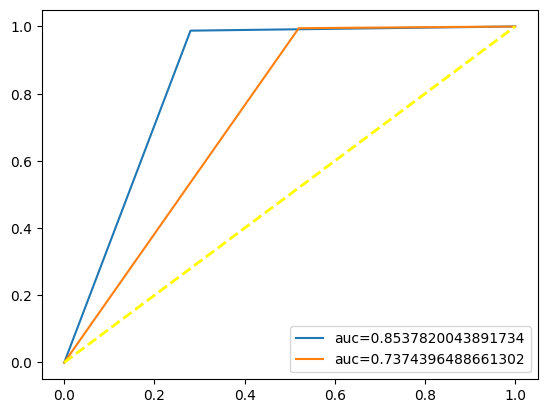

In [50]:
# roc curve for knn and svm
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_svm)
fprkn, tprkn, thresholdskn = roc_curve(y_test, y_pred_kn)
auc = roc_auc_score(y_test, y_pred_svm)
auc_kn = roc_auc_score(y_test, y_pred_kn)

plt.plot(fpr, tpr, label="auc="+str(auc))
plt.plot(fprkn, tprkn, label="auc="+str(auc_kn))
plt.plot([0, 1], [0, 1], color='yellow', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()


## 5.2. avec un reseau de neurones

    Nous avons utilisé la bibliothèque tensorflow.keras pour construire un reseau de neurones.